## Train a VAE

In [11]:
from autoencodix.utils.default_config import DefaultConfig
import autoencodix as acx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


# sample_data = np.random.rand(1000, 100)
sample_data = pd.read_parquet('../data/RNA_data.parquet')
sample_data = sample_data.to_numpy()

my_config = DefaultConfig(learning_rate=0.001, epochs=100, checkpoint_interval=1, beta=0.1)

custom_train_indices, custom_valid_indices, custom_test_indices = np.split(
	np.arange(len(sample_data)),
	[int(.6*len(sample_data)), int(.8*len(sample_data))])



# the custom split needs to be a dictionary with keys "train", "valid", and "test" and indices of the samples to be included in each split as numpy arrays
custom_split = {
    "train": custom_train_indices,
    "valid": custom_valid_indices,
    "test": custom_test_indices,
}


varix = acx.Varix(data=sample_data, config=my_config, custom_splits=custom_split)
result = varix.run()

print(
	result.latentspaces.get(epoch=34,split='valid').shape[0] +
	result.latentspaces.get(epoch=34,split='train').shape[0] +
	result.latentspaces.get(epoch=-1,split='test').shape[0]
	)
print(sample_data.shape[0])

# ## Show 1-3 most relevant plots like loss, latent space, ... 
# varix.show_result()


# ## Show specific plot for relative loss contribution
# result.show_loss(type='relative')

# ## Save all plots to a specific directory
# result.save_plots(path='./my_varix_plots/', which='all', format='png')
# which= list(result.plots.keys())
# print(which)


cpu not relevant here
[500, 125, 31, 16, 16]
Epoch: 0, Loss: 75.65368592739105
Epoch: 1, Loss: 70.44919431209564
Epoch: 2, Loss: 65.44773983955383
Epoch: 3, Loss: 63.814037442207336
Epoch: 4, Loss: 62.86584931612015
Epoch: 5, Loss: 62.03376281261444
Epoch: 6, Loss: 61.95120084285736
Epoch: 7, Loss: 61.79408419132233
Epoch: 8, Loss: 61.72034674882889
Epoch: 9, Loss: 61.09466540813446
Epoch: 10, Loss: 60.81848043203354
Epoch: 11, Loss: 61.11387938261032
Epoch: 12, Loss: 61.07853329181671
Epoch: 13, Loss: 60.91832685470581
Epoch: 14, Loss: 60.88580143451691
Epoch: 15, Loss: 60.77266079187393
Epoch: 16, Loss: 60.57568097114563
Epoch: 17, Loss: 60.544990837574005
Epoch: 18, Loss: 60.43956309556961
Epoch: 19, Loss: 60.55218654870987
Epoch: 20, Loss: 60.45563793182373
Epoch: 21, Loss: 60.538568675518036
Epoch: 22, Loss: 60.54342347383499
Epoch: 23, Loss: 60.35126441717148
Epoch: 24, Loss: 60.45179033279419
Epoch: 25, Loss: 60.44475430250168
Epoch: 26, Loss: 60.12623953819275
Epoch: 27, Loss: 

In [5]:
result.latentspaces.get(epoch=-1,split='test').shape[0]

740

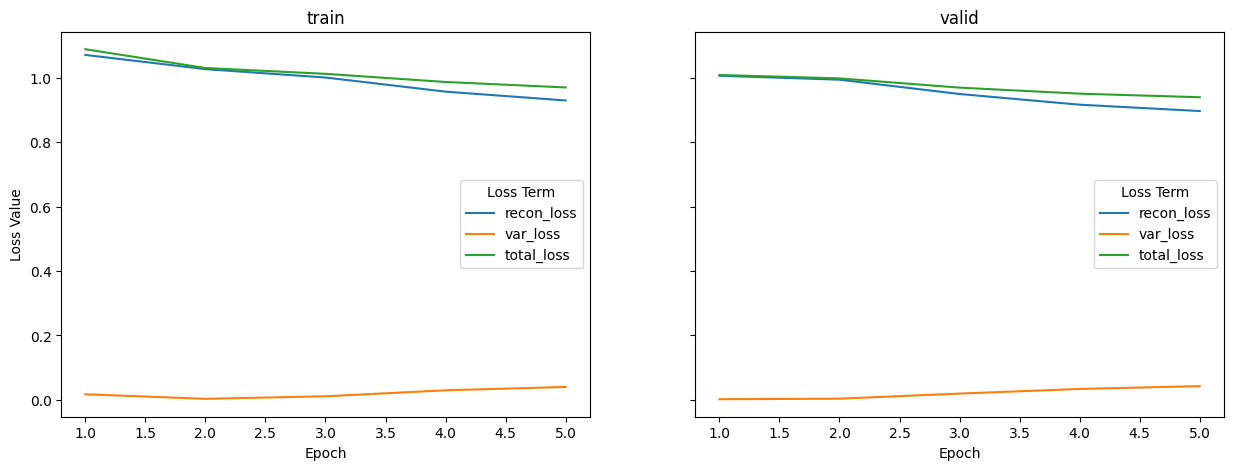

In [2]:

result.show_loss(type='absolute')

## Loss plot development

In [2]:
loss_df_melt = pd.DataFrame()

for term in result.sub_losses.keys():
	loss_df = pd.DataFrame.from_dict(
		result.sub_losses.get(key=term).get(),
		orient='index'
		)
	## Make weighting of loss terms 
	if term == "var_loss":
		loss_df = loss_df *  varix.config.beta

	loss_df['Epoch'] = loss_df.index +1
	loss_df['Loss Term'] = term

	# print(loss_df)
	loss_df_melt = pd.concat([	loss_df_melt, 
								loss_df.melt(id_vars=['Epoch','Loss Term'], var_name='Split', value_name='Loss Value')],
								axis=0).reset_index(drop=True)


loss_df = pd.DataFrame.from_dict(
	result.losses.get(),
	orient='index'
		)
loss_df['Epoch'] = loss_df.index +1
loss_df['Loss Term'] = 'total_loss'
loss_df_melt = pd.concat([	loss_df_melt, 
							loss_df.melt(id_vars=['Epoch','Loss Term'], var_name='Split', value_name='Loss Value')],
							axis=0).reset_index(drop=True)
							
loss_df_melt['Loss Value'] = loss_df_melt['Loss Value'].astype(float)

In [3]:
result.sub_losses.keys()

dict_keys(['recon_loss', 'var_loss'])

In [4]:
my_config.get_params()['beta']

{'type': "<class 'float'>",
 'default': 0.1,
 'description': 'Beta weighting factor for VAE loss'}

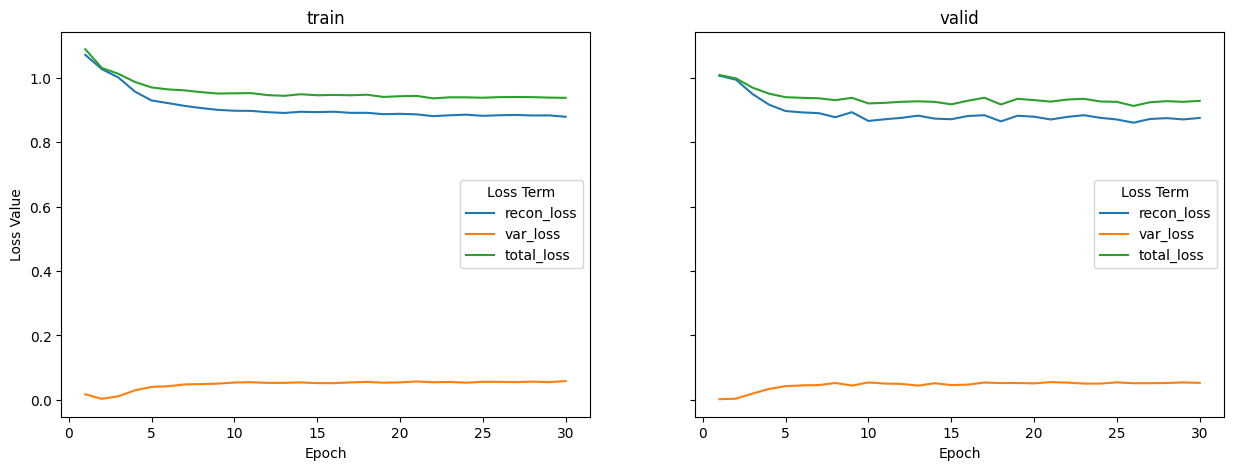

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax = 0

for split in loss_df_melt['Split'].unique():
	sns.lineplot(data=loss_df_melt[(loss_df_melt['Split'] == split)], x="Epoch", y="Loss Value", hue="Loss Term", ax=axes[ax])
	axes[ax].set_title(split)
	ax += 1

# sns.FacetGrid(loss_df_melt, col='Split', hue='Loss Term', height=5).map(sns.lineplot, 'Epoch', 'Loss Value').add_legend()

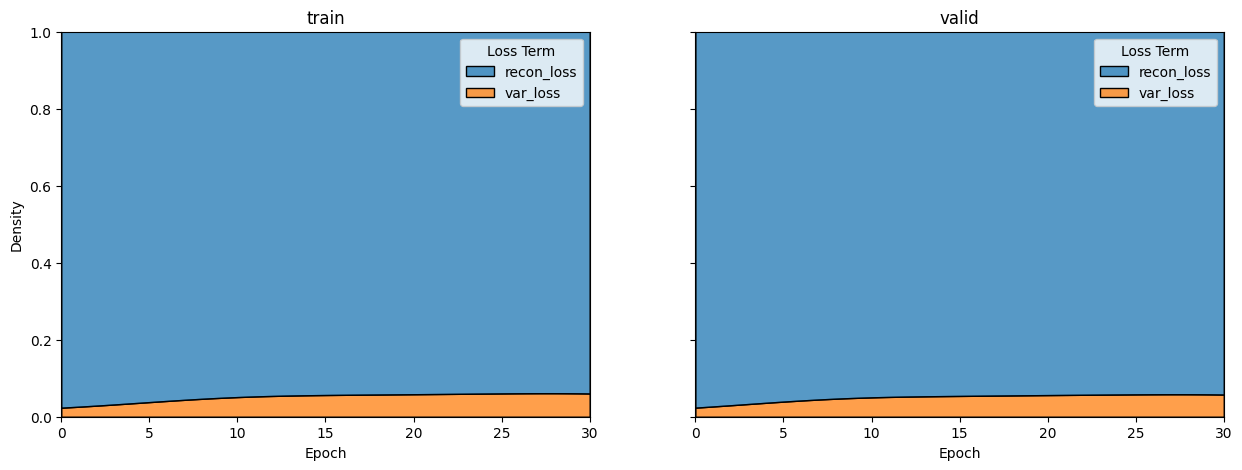

In [7]:
exclude = loss_df_melt['Loss Term'] != 'total_loss'

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax = 0

for split in loss_df_melt['Split'].unique():
	sns.kdeplot(data=loss_df_melt[exclude & (loss_df_melt['Split'] == split)], x="Epoch", hue="Loss Term", multiple="fill", weights="Loss Value",clip=[0,30], ax=axes[ax])
	axes[ax].set_title(split)
	ax += 1

## Latent Space visualizations

In [24]:
## from AUTOENCODIX
def plot_latent_ridge(lat_space, clin_data, param, save_fig=""):
    """
    Creates a ridge line plot of latent space dimension where each row shows the density of a latent dimension and groups (ridges).
    ARGS:
        lat_space (pd.DataFrame): DataFrame containing the latent space intensities for samples (rows) and latent dimensions (columns)
        clin_data (pd.DataFrame): DataFrame containing the clinical parameters to create groupings and coloring of ridges
        param (str): Clinical parameter to create groupings and coloring of ridges. Must be a column name (str) of clin_data
        save_fig (str): Path specifying save name and location.
    RETURNS:
        fig (matplotlib.figure): Figure handle (of last plot)
    """
    sns.set_theme(
        style="white", rc={"axes.facecolor": (0, 0, 0, 0)}
    )  ## Necessary to enforce overplotting

    df = pd.melt(lat_space, var_name="latent dim", value_name="latent intensity")
    df["sample"] = len(lat_space.columns) * list(
        lat_space.index.str.removeprefix("FROM_").str.removeprefix("TO_")
    )
    df = df.join(clin_data[param], on="sample")

    labels = df[param]
    # print(labels[0])
    if not (type(labels[0]) is str):
        if len(np.unique(labels)) > 3:
            labels = pd.qcut(
                labels, q=4, labels=["1stQ", "2ndQ", f"3rdQ", f"4thQ"]
            ).astype(str)
        else:
            labels = [str(x) for x in labels]
    df[param] = labels

    exclude_missing_info = (df[param] == "unknown") | (df[param] == "nan")

    xmin = (
        df.loc[~exclude_missing_info, ["latent intensity", "latent dim", param]]
        .groupby([param, "latent dim"], observed=False)
        .quantile(0.05)
        .min()
    )
    xmax = (
        df.loc[~exclude_missing_info, ["latent intensity", "latent dim", param]]
        .groupby([param, "latent dim"], observed=False)
        .quantile(0.9)
        .max()
    )

    if len(np.unique(df[param])) > 8:
        cat_pal = sns.husl_palette(len(np.unique(df[param])))
    else:
        cat_pal = sns.color_palette(n_colors=len(np.unique(df[param])))

    g = sns.FacetGrid(
        df[~exclude_missing_info],
        row="latent dim",
        hue=param,
        aspect=12,
        height=0.8,
        xlim=(xmin.iloc[0], xmax.iloc[0]),
        palette=cat_pal,
    )

    g.map_dataframe(
        sns.kdeplot,
        "latent intensity",
        bw_adjust=0.5,
        clip_on=True,
        fill=True,
        alpha=0.5,
        warn_singular=False,
        ec="k",
        lw=1,
    )

    def label(data, color, label, text="latent dim"):
        ax = plt.gca()
        label_text = data[text].unique()[0]
        ax.text(
            0.0,
            0.2,
            label_text,
            fontweight="bold",
            ha="right",
            va="center",
            transform=ax.transAxes,
        )

    g.map_dataframe(label, text="latent dim")

    g.set(xlim=(xmin.iloc[0], xmax.iloc[0]))
    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-0.5)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    g.add_legend()

    if len(save_fig) > 0:
        g.savefig(save_fig)

    return g

In [13]:
sample_anno= pd.read_parquet('../data/ANNO_data.parquet')
print(sample_anno)

sample_rna= pd.read_parquet('../data/RNA_data.parquet')
# sample_rna

                 clusters_coarse       clusters   S_score  G2M_score  \
index                                                                  
AAACCTGAGAGGGATA   Pre-endocrine  Pre-endocrine -0.224902  -0.252071   
AAACCTGAGCCTTGAT          Ductal         Ductal -0.014707  -0.232610   
AAACCTGAGGCAATTA       Endocrine          Alpha -0.171255  -0.286834   
AAACCTGCATCATCCC          Ductal         Ductal  0.599244   0.191243   
AAACCTGGTAAGTGGC    Ngn3 high EP   Ngn3 high EP -0.179981  -0.126030   
...                          ...            ...       ...        ...   
TTTGTCAAGTGACATA   Pre-endocrine  Pre-endocrine -0.235896  -0.266101   
TTTGTCAAGTGTGGCA    Ngn3 high EP   Ngn3 high EP  0.279374  -0.204047   
TTTGTCAGTTGTTTGG          Ductal         Ductal -0.045692  -0.208907   
TTTGTCATCGAATGCT       Endocrine          Alpha -0.240576  -0.206865   
TTTGTCATCTGTTTGT       Endocrine        Epsilon -0.136407  -0.184763   

                  initial_size_unspliced  initial_size_spliced 

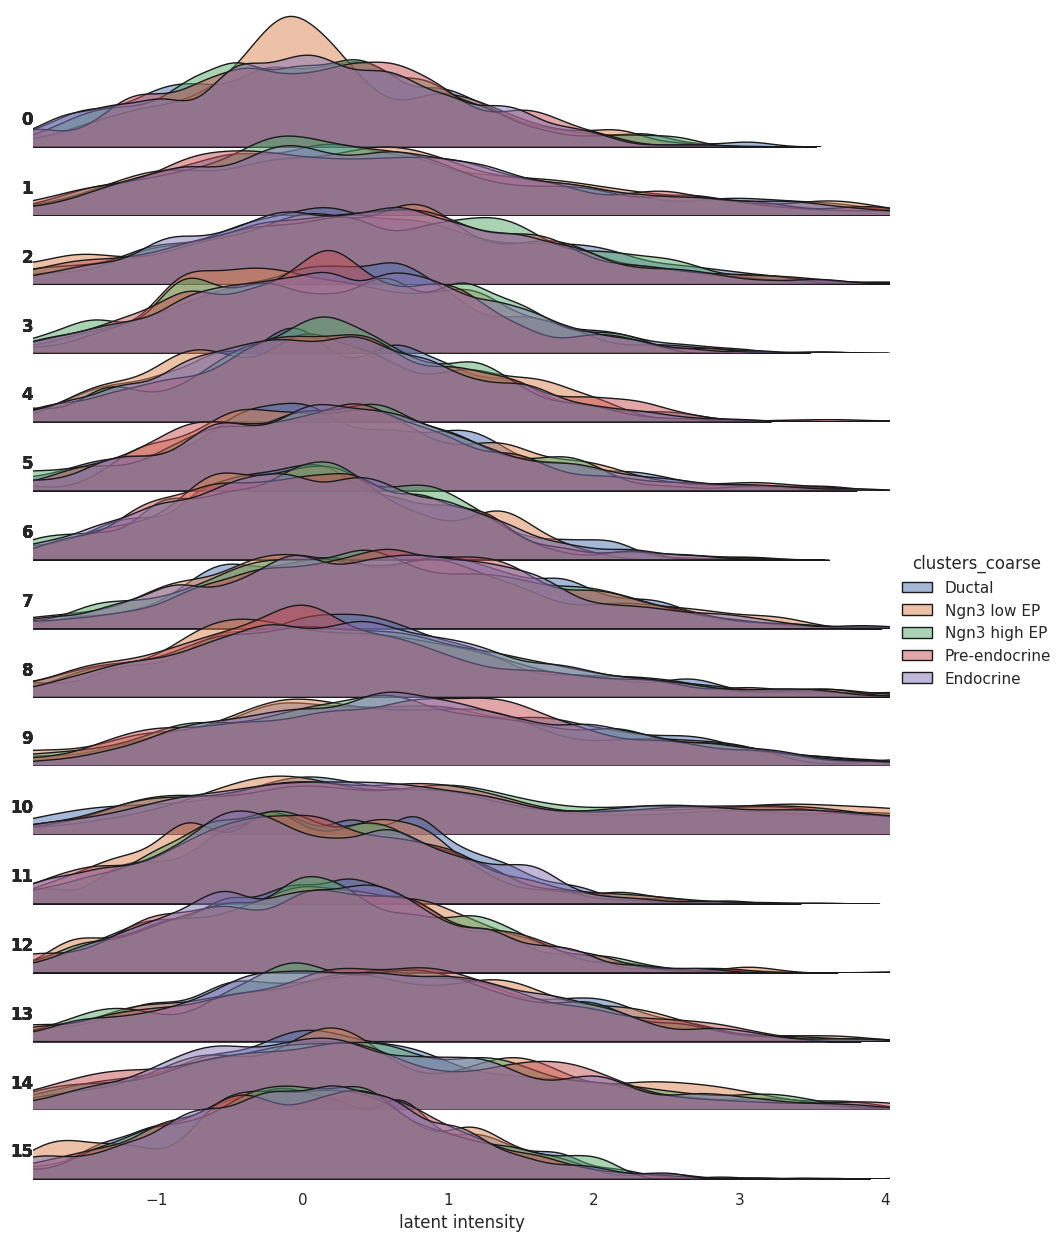

In [25]:
lat_space = pd.DataFrame(result.latentspaces.get(epoch=34, split='train'))

lat_space.index = sample_rna.index[custom_train_indices] ## Not meaningful index association since train/test split indices unknown

plot_latent_ridge(lat_space=lat_space, clin_data=sample_anno, param='clusters_coarse')